**Time Series Forecasting Using Transformer Network:**
- Transformer model to forecast time series sequences of stock closing prices
- Using 10 timesteps to forecast 1 forward timestep

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

In [2]:
from utils.tx_resources import *

In [3]:
from torch.utils.data import Dataset, DataLoader

Load dataset and set global variables:

In [4]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps -> this model is fixed to 1
batch_size = 250

device = torch.device("mps" if torch.mps.is_available() else "cpu")
print("Device is: ",device)

Device is:  mps


In [5]:
# read the training dataset
path = r"/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/data/ts_dataset/facebook.csv"
df = pd.read_csv(path)
df.head()

,date,minute,label,high,low,open,close,average,volume,notional,...,rsi,long,exit_long,short,exit_short,long_pnl,short_pnl,total_pnl,long_labels,short_labels
0,2019-04-01,09:30,09:30 AM,168.000,167.52,167.925,167.82,167.775,9294.0,1559300.720,...,NaN,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
1,2019-04-01,09:31,09:31 AM,168.190,167.76,167.760,168.19,167.908,863.0,144904.500,...,100.000000,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
2,2019-04-01,09:32,09:32 AM,168.630,168.36,168.390,168.36,168.490,2707.0,456101.680,...,100.000000,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
3,2019-04-01,09:33,09:33 AM,168.135,167.94,168.135,168.04,168.132,5503.0,925229.920,...,46.468401,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN
4,2019-04-01,09:34,09:34 AM,168.200,168.00,168.045,168.01,168.189,15236.0,2562520.845,...,43.215212,NaN,167.925,NaN,167.805,NaN,NaN,0.0,NaN,NaN


**Preprocessing:**
- transforms applied: logarithmic normalization => applying a log transform to the values in order to compress large ranges, reduce skewness and stablize variance over time
- in finance however, they are looking for returns and how the returns change so preprocessing involves taking the log of the values then taking the difference to compute the log return
- taking the cumulative sum then ensures all series begin at the same point in time - 0
- cumsum returns the global relative growth 
- doing the cumsum ensures that:
  - the starting value is 0
  - everything is expressed relative to the first price
  - absolute price level is gone
- rationale: to remove the arbitrary starting price

In [6]:
# logarithmic normalization
open_ = df["open"].fillna(method="ffill") # using forward fill to fill null values in the open column
open_ = np.array(open_) # conversion to a numpy array
open_logreturn = np.diff(np.log(open_)) # computing the log return 
open_csum_logreturn = open_logreturn.cumsum() # global returns starting at 0

close = df["close"].fillna(method="ffill")
close = np.array(close)
close_logreturn = np.diff(np.log(close))
close_csum_logreturn = close_logreturn.cumsum()

average = df["average"].fillna(method="ffill")
average = np.array(average)
average_logreturn = np.diff(np.log(average))
average_csum_logreturn = average_logreturn.cumsum()

/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_9700/822384468.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  open_ = df["open"].fillna(method="ffill") # using forward fill to fill null values in the open column
/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_9700/822384468.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close = df["close"].fillna(method="ffill")
/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_9700/822384468.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  average = df["average"].fillna(method="ffill")
/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_9700/822384468.py:14: RuntimeWarning: invalid value encountered in log
  average_logreturn = np.diff(np

Plot the input dataframes:

Text(0, 0.5, 'average Price')

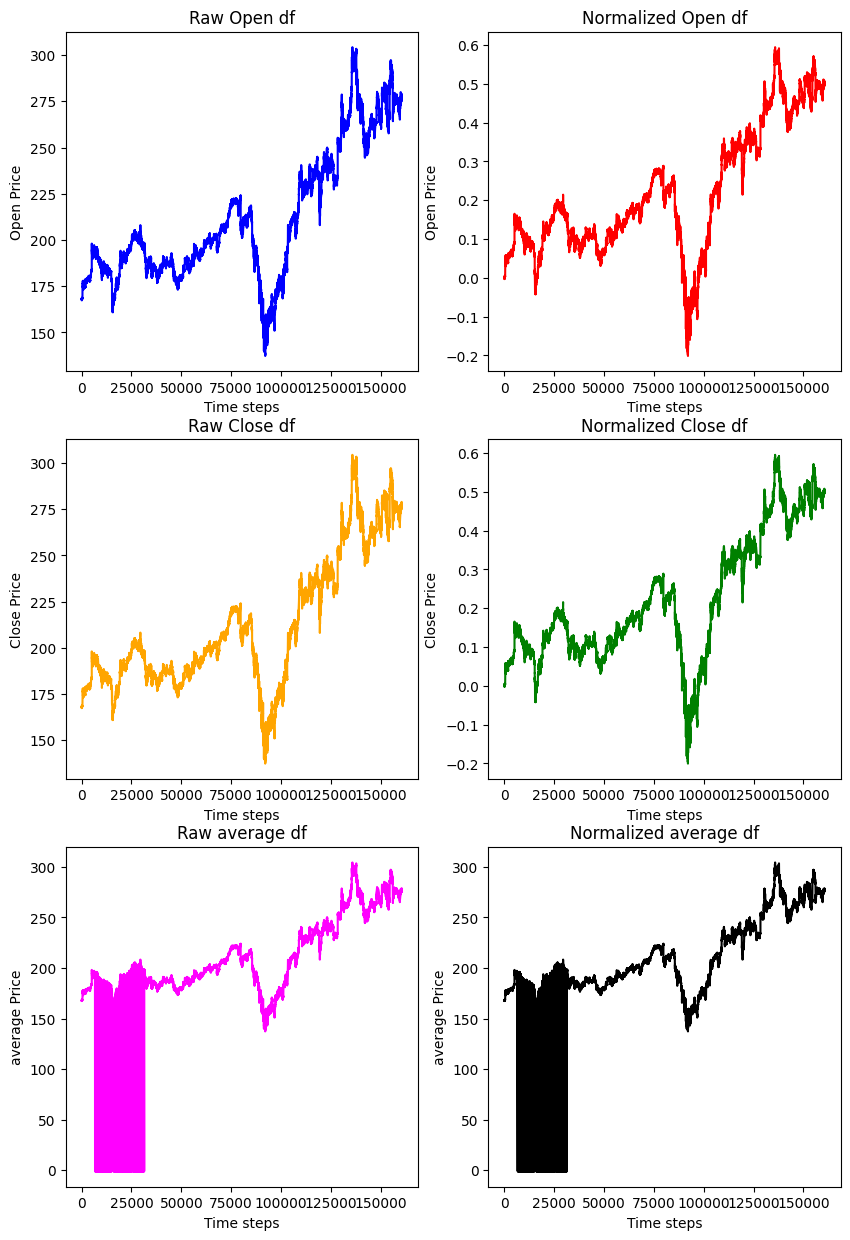

In [7]:
fig, ax = plt.subplots(3,2, figsize=(10,15))

ax[0,0].plot(open_, color="blue")
ax[0,0].set_title("Raw Open df")
ax[0,0].set_xlabel("Time steps")
ax[0,0].set_ylabel("Open Price")

ax[0,1].plot(open_csum_logreturn, color="red")
ax[0,1].set_title("Normalized Open df")
ax[0,1].set_xlabel("Time steps")
ax[0,1].set_ylabel("Open Price")

ax[1,0].plot(close, color="orange")
ax[1,0].set_title("Raw Close df")
ax[1,0].set_xlabel("Time steps")
ax[1,0].set_ylabel("Close Price")

ax[1,1].plot(close_csum_logreturn, color="green")
ax[1,1].set_title("Normalized Close df")
ax[1,1].set_xlabel("Time steps")
ax[1,1].set_ylabel("Close Price")

ax[2,0].plot(average, color="magenta")
ax[2,0].set_title("Raw average df")
ax[2,0].set_xlabel("Time steps")
ax[2,0].set_ylabel("average Price")

ax[2,1].plot(average, color="black")
ax[2,1].set_title("Normalized average df")
ax[2,1].set_xlabel("Time steps")
ax[2,1].set_ylabel("average Price")


Process the data for training:

we use the closelogrun data for training and validation, lets process it just like the finance guy did...

In [8]:
def create_splits(data, split):
    series = data
    split = round(split * len(series)) # training split percentage value
    train_data = series[:split]
    val_data = series[split:]
    # do the required cumumalative sum thing
    train_data = train_data.cumsum()
    # do their augmentation thing as well
    train_data = 2 * train_data

    # cumul sum the val dataset as well
    val_data = val_data.cumsum()
    return train_data, val_data

In [9]:
train_data, val_data = create_splits(close_logreturn, 0.6)

Build the chunks..
- sort of doing teacher forcing here - with the labels being one timestep ahead of the training data

In [10]:
def build_chunks(data, window):
    # convert the data to a list
    in_chunks = []
    lab_chunks = []
    data = data.tolist()
    for i in range(len(data)-window):
        in_chunks.append(data[i:i+window])
        lab_chunks.append(data[i+1:i+1+window])
    return torch.tensor(in_chunks), torch.tensor(lab_chunks)

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, input_chunks, label_chunks):
        self.input_chunks = input_chunks
        self.label_chunks = label_chunks
    
    def __len__(self):
        return len(self.input_chunks)
    
    def __getitem__(self, index):
        x, y = self.input_chunks[index], self.label_chunks[index]
        return x,y

Build the training and validation chunks now:

In [12]:
train_x_chunks, train_y_chunks = build_chunks(train_data, window=10)
val_x_chunks, val_y_chunks = build_chunks(val_data, window=10)

train_ds = TimeSeriesDataset(train_x_chunks, train_y_chunks)
val_ds = TimeSeriesDataset(val_x_chunks, val_y_chunks)

Build the batches:

In [13]:
train_dl = DataLoader(train_ds, batch_size=250, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=250)

Now work on building the model:

In [44]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(1, feature_size)
        self.pos_embed = PositionalEmbedding(max_length=100, embed_dim=feature_size, dropout=dropout)
        self.transformer = Transformer(d_model=feature_size, nheads=10, num_encoder_layers=1, dim_feedforward=2048, dropout=0.1)
        self.output = nn.Linear(feature_size, 1)
    
    def forward(self, x):
        x = x.unsqueeze(2) # get the 1 dimension for the input
        x = self.input_proj(x) # project to 250 dim embeddings
        x = self.pos_embed(x) # add positional embeddings

        # build the causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1), dtype=bool, device=x.device)

        out = self.transformer(x, causal_mask)
        out = self.output(out)
        return out

Now train the model:

In [45]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = TimeSeriesTransformer().to(device)

In [46]:
from utils.early_stopping import EarlyStopping

In [47]:
torch.manual_seed(42)
criterion = nn.MSELoss(reduction='sum')
lr = 0.00005
epochs = 200

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#early_stopper = EarlyStopping(patience=30, checkpoint_path='ts_tx.pt', restore_best_weights=True, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [48]:
train_loss = [0]*epochs
val_loss = [0]*epochs

for epoch in range(epochs):
    model.train()
    # iterate through the training data
    for inputs,labels in train_dl:
        inputs,labels = inputs.to(device), labels.unsqueeze(2).to(device)
        optimizer.zero_grad()
        out = model(inputs)
        loss =  criterion(out, labels)
        loss.backward()
        optimizer.step()
        train_loss[epoch] += loss.item()
    train_loss[epoch] /= len(train_dl.dataset)

    # eval on the val set
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs,labels = inputs.to(device),labels.unsqueeze(2).to(device)
            out = model(inputs)
            loss = criterion(out, labels)
            val_loss[epoch] += loss.item()
        val_loss[epoch] /= len(val_dl.dataset)

        scheduler.step()
        print(f'Epoch: {epoch+1}| Train loss: {train_loss[epoch]:.4f}| Val loss: {val_loss[epoch]:.4f}')
        #early_stopper(val_loss[epoch], model, optimizer, epoch)
        # if early_stopper.should_stop:
        #     print(f"Stopping at epoch: {epoch+1}")
        #     break

Epoch: 1| Train loss: 0.0935| Val loss: 0.0028
Epoch: 2| Train loss: 0.0103| Val loss: 0.0042
Epoch: 3| Train loss: 0.0060| Val loss: 0.0053
Epoch: 4| Train loss: 0.0044| Val loss: 0.0066
Epoch: 5| Train loss: 0.0037| Val loss: 0.0088
Epoch: 6| Train loss: 0.0032| Val loss: 0.0070
Epoch: 7| Train loss: 0.0029| Val loss: 0.0078
Epoch: 8| Train loss: 0.0026| Val loss: 0.0074
Epoch: 9| Train loss: 0.0024| Val loss: 0.0084
Epoch: 10| Train loss: 0.0023| Val loss: 0.0073
Epoch: 11| Train loss: 0.0022| Val loss: 0.0079
Epoch: 12| Train loss: 0.0021| Val loss: 0.0070
Epoch: 13| Train loss: 0.0019| Val loss: 0.0064
Epoch: 14| Train loss: 0.0019| Val loss: 0.0074
Epoch: 15| Train loss: 0.0018| Val loss: 0.0070
Epoch: 16| Train loss: 0.0017| Val loss: 0.0062
Epoch: 17| Train loss: 0.0017| Val loss: 0.0060
Epoch: 18| Train loss: 0.0016| Val loss: 0.0056
Epoch: 19| Train loss: 0.0016| Val loss: 0.0064
Epoch: 20| Train loss: 0.0015| Val loss: 0.0073
Epoch: 21| Train loss: 0.0015| Val loss: 0.0059
E

KeyboardInterrupt: 

Need to use the validation dataset to forecast and see if this makes sense:

In [49]:
model.eval()

TimeSeriesTransformer(
  (input_proj): Linear(in_features=1, out_features=250, bias=True)
  (pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiHeadAttention(
            (q_proj): Linear(in_features=250, out_features=250, bias=True)
            (k_proj): Linear(in_features=250, out_features=250, bias=True)
            (v_proj): Linear(in_features=250, out_features=250, bias=True)
            (out_proj): Linear(in_features=250, out_features=250, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (linear1): Linear(in_features=250, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=250, bias=True)
          (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
          

In [50]:
z = torch.randn(250,10,1)
z = z.view(-1)
z.shape

torch.Size([2500])

In [51]:
loss_crit = nn.MSELoss(reduction='sum')

In [52]:
ins = []
pres = []
loss = 0
for inputs,labels in val_dl:
    with torch.no_grad():
        out = model(inputs.to(device))
        ins = ins+labels.view(-1).cpu().numpy().tolist()
        pres = pres + out.view(-1).cpu().numpy().tolist()
        loss += loss_crit(out, labels.unsqueeze(2).to(device))

In [53]:
loss/len(val_dl.dataset)

tensor(0.0045, device='mps:0')

In [54]:
len(ins)

642610

In [55]:
len(pres)

642610

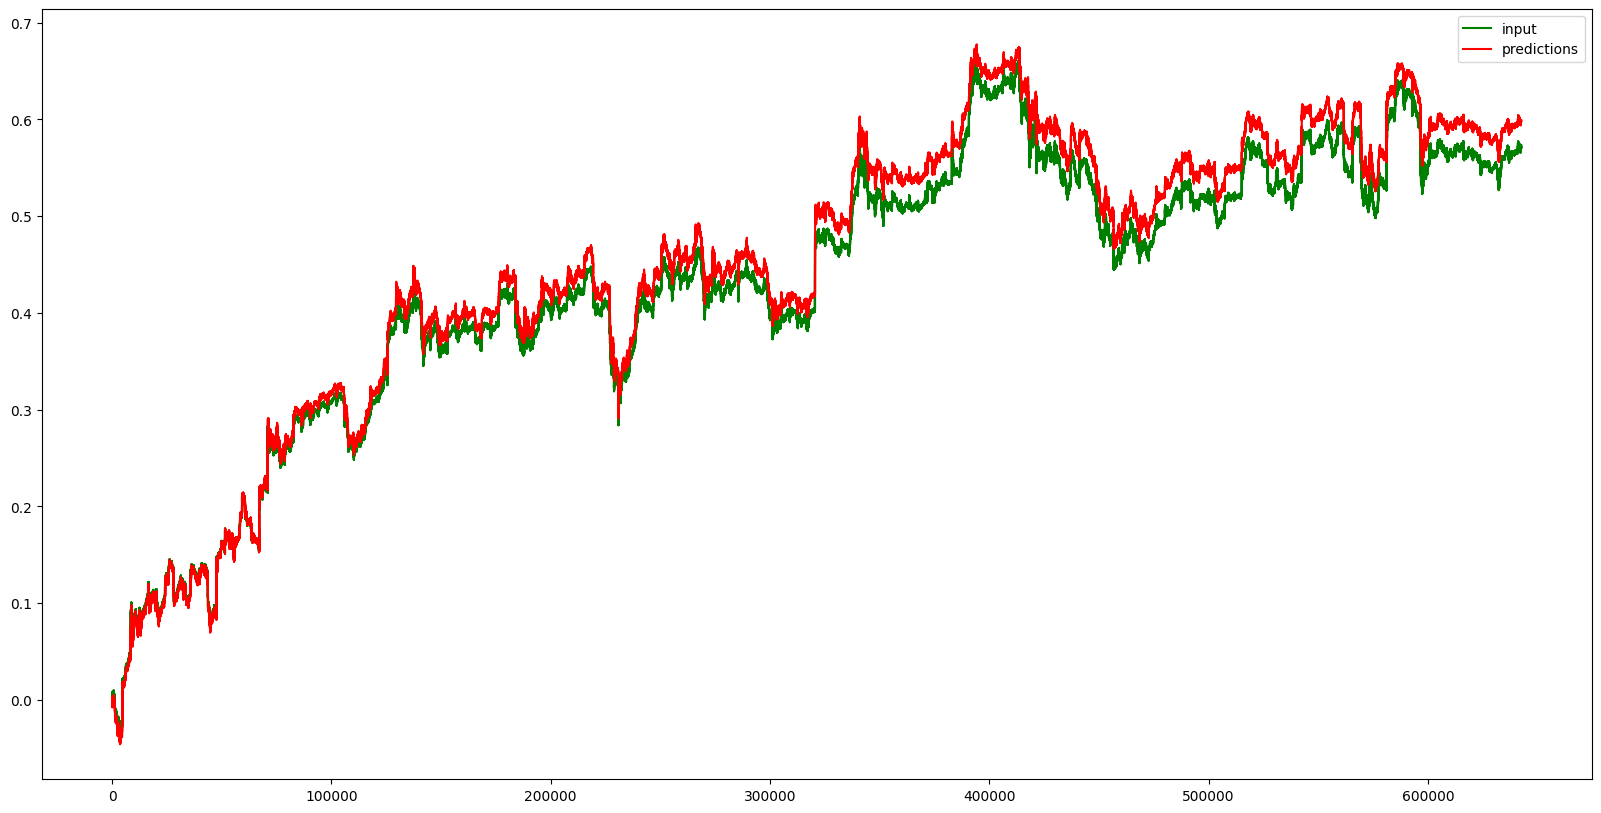

In [58]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(ins, label="input", color='green')
ax.plot(pres, label='predictions', color='red')
ax.legend()

Load and do the same testing on the JP Morgan and Boeing datasets

In [ ]:
def process_data(data):
    # do the required cumumalative sum thing
    data = data.cumsum()
    # do their augmentation thing as well
    train_data = 2 * train_data

    # cumul sum the val dataset as well
    val_data = val_data.cumsum()
    return train_data, val_data

In [64]:
path = r"/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/data/ts_dataset/boeing.csv"
boeing = pd.read_csv(path)

close = boeing["close"].fillna(method="ffill")
close = np.array(close)
close_logreturn = np.diff(np.log(close))
close_csum_logreturn = close_logreturn.cumsum()

boeing_x_chunks, boeing_y_chunks = build_chunks(close_csum_logreturn, window=10)

boeing_ds = TimeSeriesDataset(boeing_x_chunks, boeing_y_chunks)

boeing_dl = DataLoader(boeing_ds, batch_size=250)

/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_9700/293424613.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close = boeing["close"].fillna(method="ffill")


In [65]:
model.eval()

TimeSeriesTransformer(
  (input_proj): Linear(in_features=1, out_features=250, bias=True)
  (pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiHeadAttention(
            (q_proj): Linear(in_features=250, out_features=250, bias=True)
            (k_proj): Linear(in_features=250, out_features=250, bias=True)
            (v_proj): Linear(in_features=250, out_features=250, bias=True)
            (out_proj): Linear(in_features=250, out_features=250, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (linear1): Linear(in_features=250, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=250, bias=True)
          (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
          

In [66]:
loss_crit = nn.MSELoss(reduction='sum')
ins = []
pres = []
loss = 0
for inputs,labels in boeing_dl:
    with torch.no_grad():
        out = model(inputs.to(device))
        ins = ins+labels.view(-1).cpu().numpy().tolist()
        pres = pres + out.view(-1).cpu().numpy().tolist()
        loss += loss_crit(out, labels.unsqueeze(2).to(device))

In [67]:
loss/len(boeing_dl.dataset)

tensor(0.1332, device='mps:0')

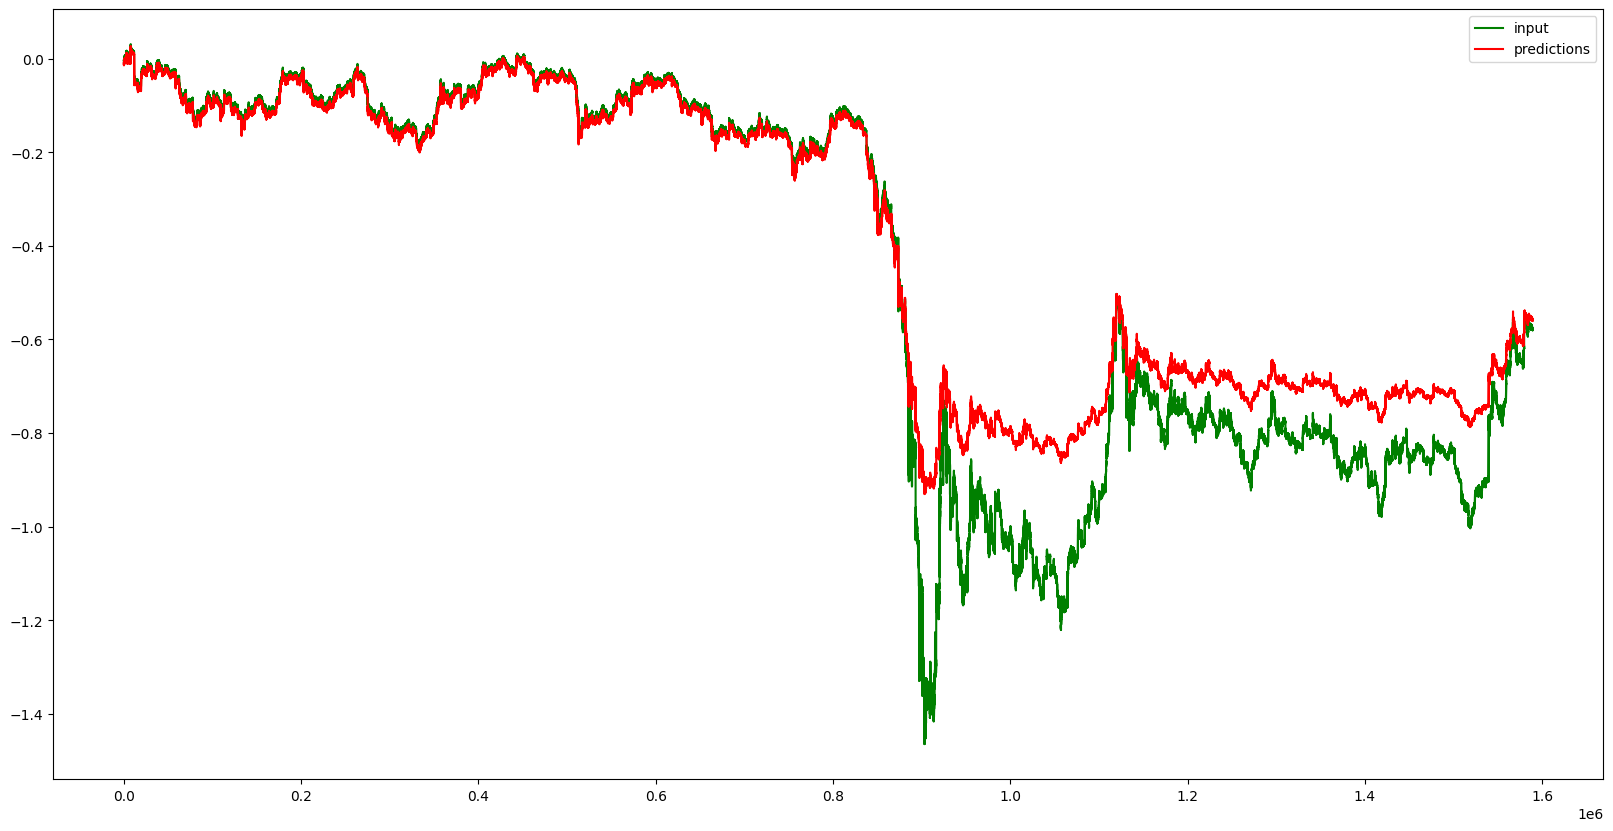

In [68]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(ins, label="input", color='green')
ax.plot(pres, label='predictions', color='red')
ax.legend()

jp morgan:

In [69]:
path = r"/Users/blaise/Documents/ML/Machine-Learning-and-Big-Data-Analytics/data/ts_dataset/jp_morgan.csv"
jp_morgan = pd.read_csv(path)

close = jp_morgan["close"].fillna(method="ffill")
close = np.array(close)
close_logreturn = np.diff(np.log(close))
close_csum_logreturn = close_logreturn.cumsum()

jp_morgan_x_chunks, jp_morgan_y_chunks = build_chunks(close_csum_logreturn, window=10)

jp_morgan_ds = TimeSeriesDataset(jp_morgan_x_chunks, jp_morgan_y_chunks)

jp_morgan_dl = DataLoader(jp_morgan_ds, batch_size=250)

/var/folders/_h/yzv4_kzj2yv3z5xh7lks3hpr0000gn/T/ipykernel_9700/3048442851.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close = jp_morgan["close"].fillna(method="ffill")


In [70]:
model.eval()

TimeSeriesTransformer(
  (input_proj): Linear(in_features=1, out_features=250, bias=True)
  (pos_embed): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiHeadAttention(
            (q_proj): Linear(in_features=250, out_features=250, bias=True)
            (k_proj): Linear(in_features=250, out_features=250, bias=True)
            (v_proj): Linear(in_features=250, out_features=250, bias=True)
            (out_proj): Linear(in_features=250, out_features=250, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (linear1): Linear(in_features=250, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=250, bias=True)
          (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
          

In [71]:
loss_crit = nn.MSELoss(reduction='sum')
ins = []
pres = []
loss = 0
for inputs,labels in jp_morgan_dl:
    with torch.no_grad():
        out = model(inputs.to(device))
        ins = ins+labels.view(-1).cpu().numpy().tolist()
        pres = pres + out.view(-1).cpu().numpy().tolist()
        loss += loss_crit(out, labels.unsqueeze(2).to(device))

In [72]:
loss/len(jp_morgan_dl.dataset)

tensor(0.0004, device='mps:0')

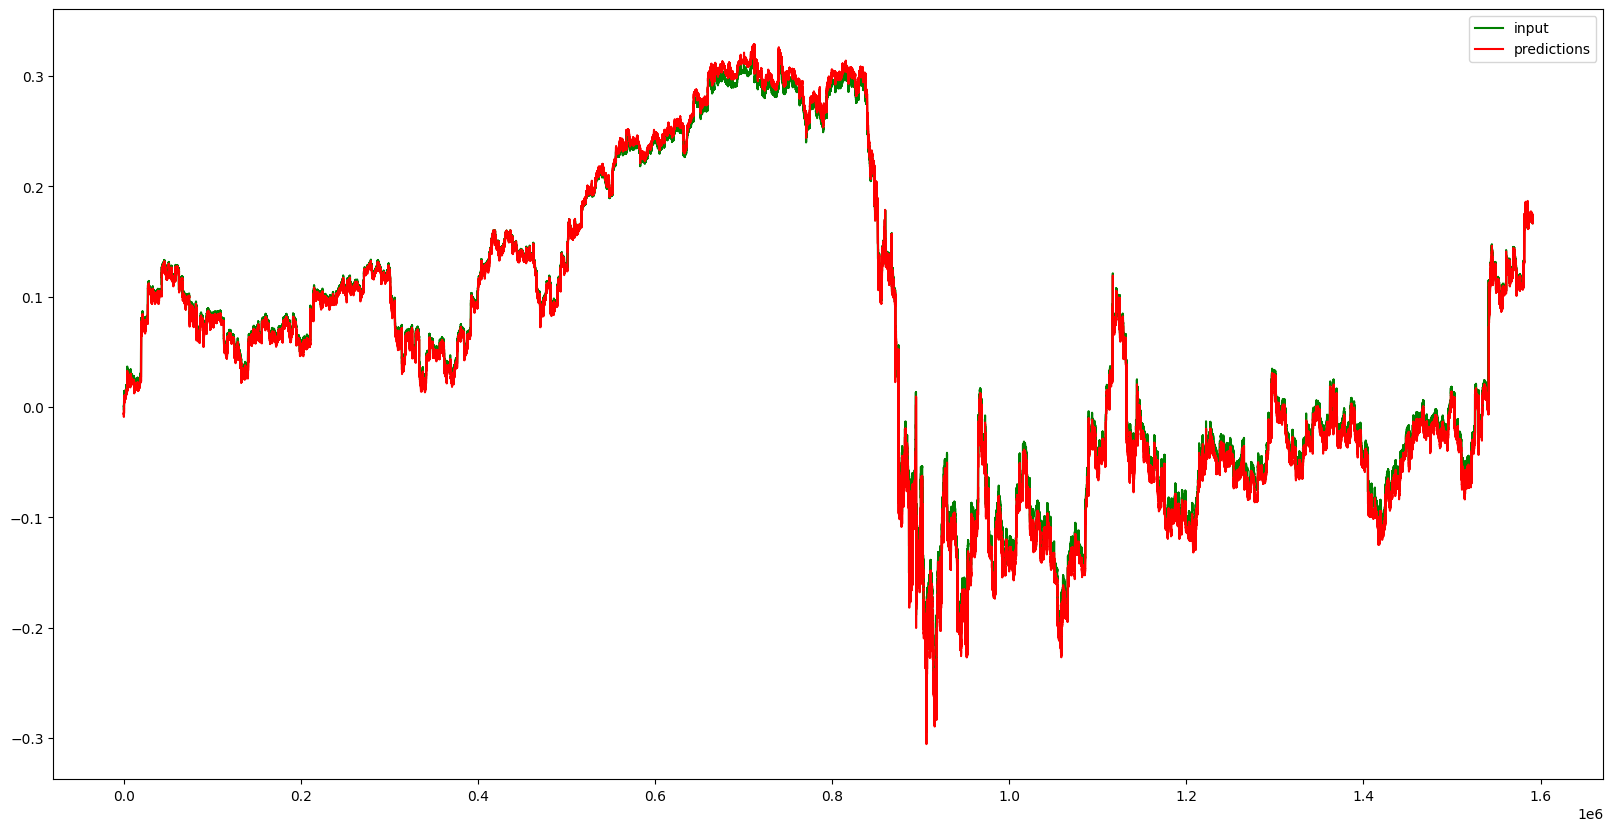

In [73]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(ins, label="input", color='green')
ax.plot(pres, label='predictions', color='red')
ax.legend()